
# Web Scraping 101

The web is a huge source of information and data but often the information is presented in an unhelpful manner. Sometimes all you need is a concise summary - this is where web scraping comes in.

Take looking for jobs as an example, do you really want to spend all evening trawling through websites when really only a handful of jobs are applicable to you? Web scraping can be used to extract specific pieces of information from multiple pages.

It's important to note, not all websites allow you to scrape their pages. Before you begin, make sure to check the terms and conditions of the website. 

This tutorial will show you how to web scrape through an example of the governments apprenticeship site (https://www.findapprenticeship.service.gov.uk) which is permitted under the OGL (Open Government License).

In this blog we will cover:
<ul>
    <li> Web scraping a single page using the Beautiful Soup library in python
    <li> Automating the process to scrape multiple page

</ul>


### Importing the packages

Before we begin, we need to import the packages that will be useful throughout this example. The _requests_ library allows us to download the data from a page. We will be using _urllib.parse_ to combine URL components into a URL string. Last but not least we will be using _BeautifulSoup_ to scrape the information from the web page HTML.

In [1]:
import pandas as pd
import requests
import urllib.parse

from bs4 import BeautifulSoup

In addition to the link shown above, we need to set some parameters to get to the page we want to scrape. For the purpose of this example, we are going to look at all levels of apprenticeships within 30 miles of Nottingham and it has been set to show 50 pages per page. 

The page we want to scrape can be seen below.

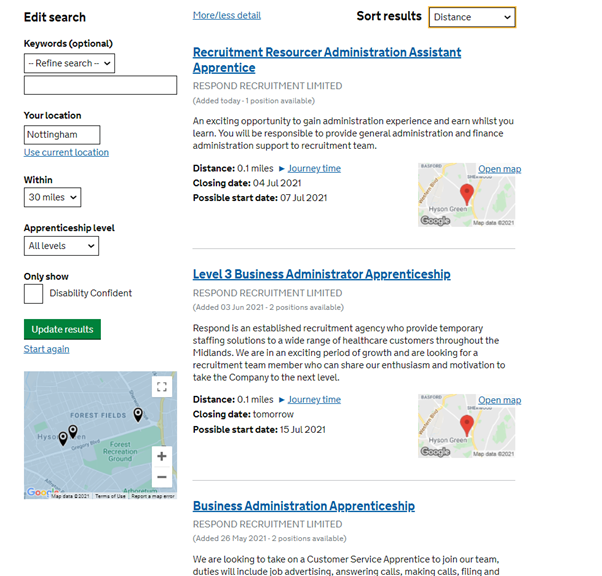

We can define these parameters beforehand and then by using _urllib.parse_ we can combine the components into a URL string.

In [2]:
# Initialising a dictionary of parameters 
params = {
        'ApprenticeshipLevel': 'All',
        'Location': 'Nottingham',
        'ResultsPerPage': 50,
        'WithinDistance': 30
    } 

### Extracting the 'soup'

As mentioned earlier, by using _requests.get_ we can download the page by inputting the website's URL. 

Below shows how to use _urllib.parse_ to join together the parameters defined in the code block above into a URL string. 

The URL string ends up being https://www.findapprenticeship.service.gov.uk/apprenticeships?ApprenticeshipLevel=All&Location=Nottingham&ResultsPerPage=50&WithinDistance=30 which also works when inputted into _requests.get_ . However, by defining the parameters beforehand, it allows you to easily change the variables. You can even write a simple loop to run over multiple locations by defining the parameters first!

In [4]:
# Extracting the HTML of the page
page = requests.get('https://www.findapprenticeship.service.gov.uk/apprenticeships?' 
                    + '&'.join(f"{k}={urllib.parse.quote(str(v))}" for k, v in params.items()))
soup = BeautifulSoup(page.content, "html.parser")

The web pages are are created in HTML. HTML is formed of many different elements. We want to find specific elements and extract these from the main content of the page.

We will be looking for unique **class** or **id** properties in the HTML code to specify which parts of the 'soup' we want to extract.

By inspecting the HTML code, we need to find the **class** _search-results_ to extract the main conent from the page. This can be done using the _find_ command as shown in the code block below.

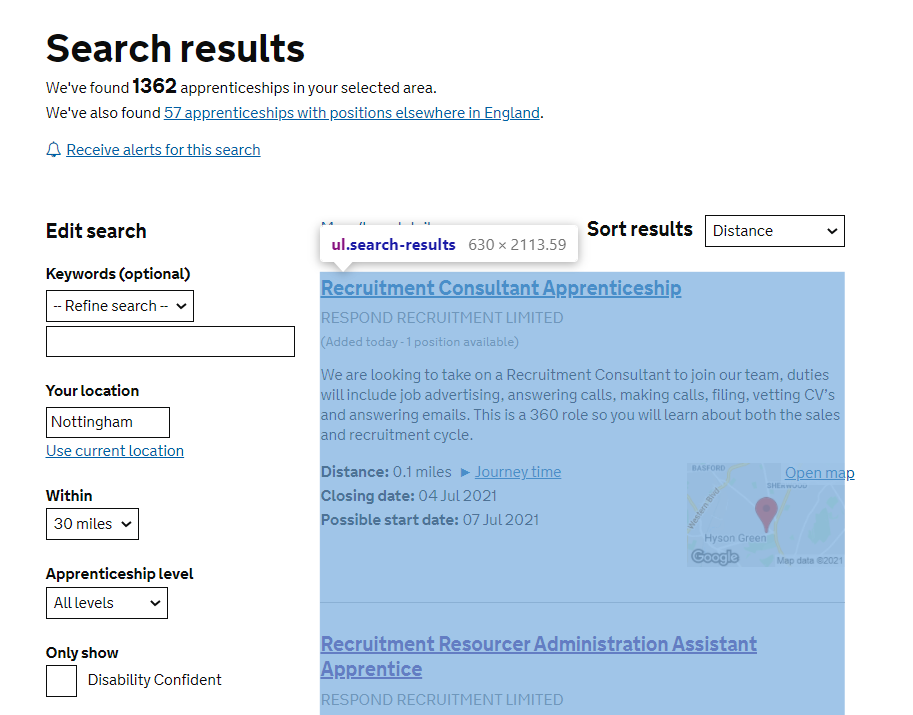

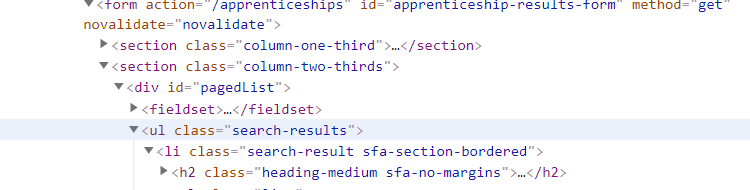

In [5]:
page_soup = soup.find(class_="search-results")

Once the main content of the page is extracted, the next step is to identify which information you want to extract from the page.
For this example, we will look at the occupation description, the company offering the apprenticeship, the apprenticeship level and the salary. First, we define these variables as empty vectors.

In [6]:
# Creating empty vectors 
occupation_description = []
company = []
apprenticeship_level = []
wage = []

Within the main content, we now need to find all of the apprenticeship adverts individually. Each apprenticeship card has the element _li_ with **class**=_research-result sfa-section-bordered_.

By finding all _li_ with **class** = _research-result_ in a similar way to that of the main content, the following piece of code can be used.

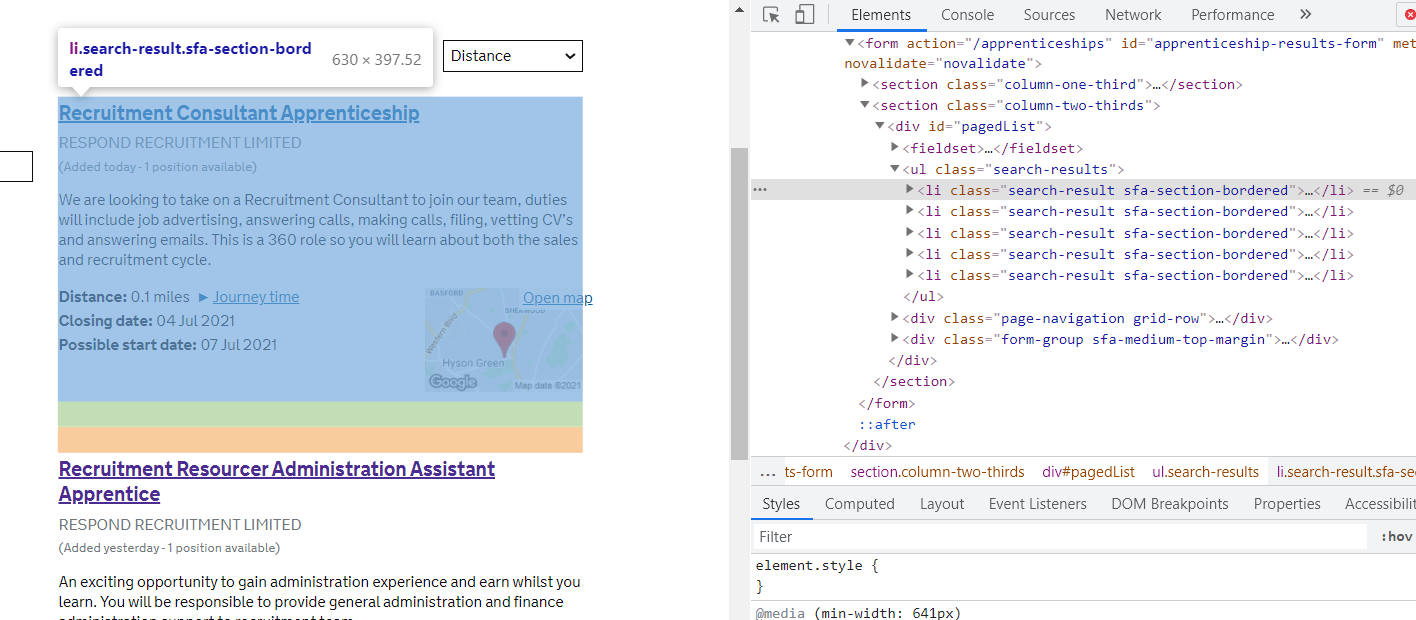

In [7]:
apprentice_cards = page_soup.find_all('li', class_="search-result")

Within each advert we can find the variables that we defined above. By inspecting each piece of important information (occupation description is used as an example in the image below) we can extract that part of the soup for each apprenticeship advert.

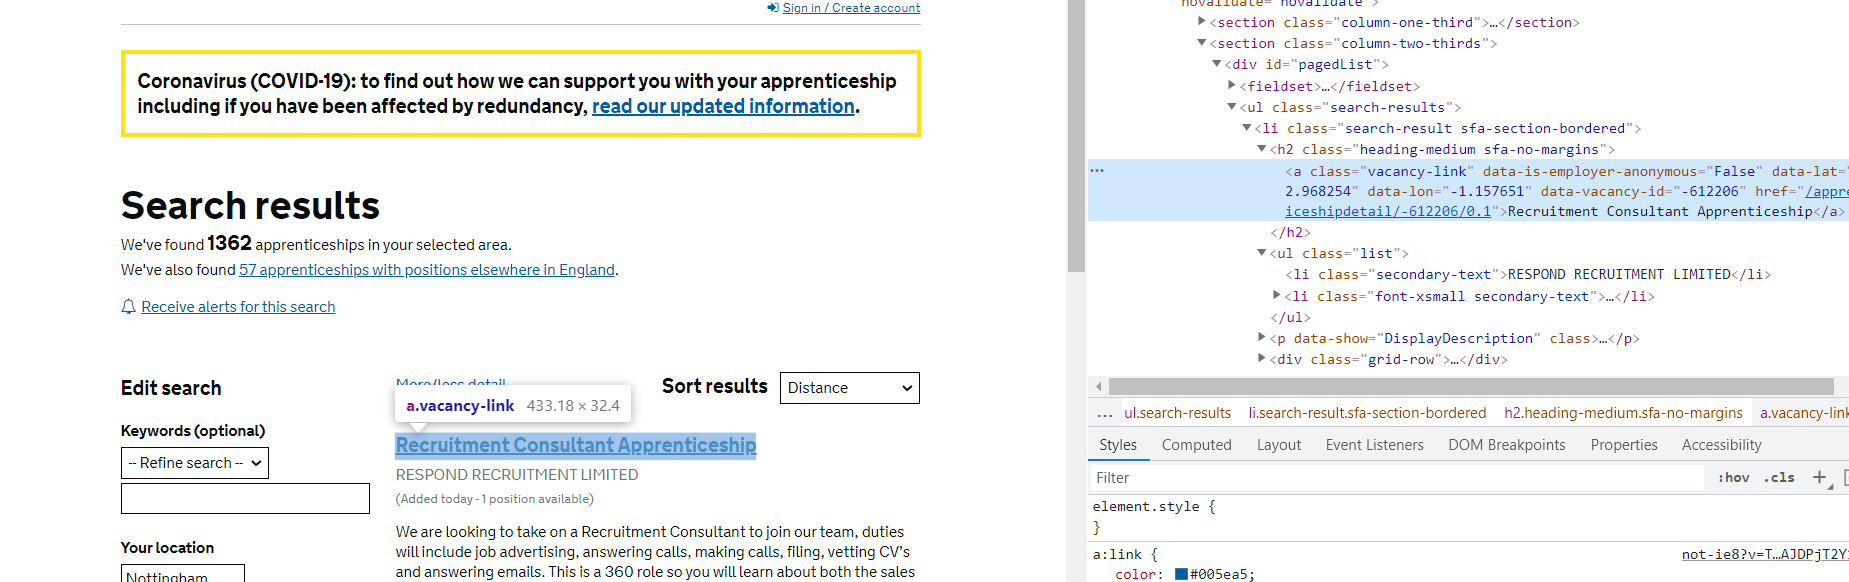

By looping over each apprenticeship advert we can find the information, extract the text and append it to a list. This is all shown in the code block below.

In [8]:
for container in apprentice_cards:
    occ_desc = container.find('a', class_='vacancy-link')
    occupation_description.append(occ_desc.text)

    comp = container.find('li', class_='secondary-text').text
    company.append(comp)

    apprentice_level = container.find('li', attrs={'data-show': 'DisplayApprenticeshipLevel'}).text
    apprentice_level = str.split(apprentice_level)[2]
    apprenticeship_level.append(apprentice_level)

    wages = container.find('li', attrs={'data-show': 'DisplayWage'}).text
    wages = str.split(wages, ':')[1].strip()
    wage.append(wages)

 

Putting all of the information into a dataframe:

In [9]:
df_apprenticeships = pd.DataFrame({
    'occupationDescription': occupation_description,
    'company': company,
    'apprenticeshipLevel': apprenticeship_level,
    'wage': wage,

})

In [10]:
df_apprenticeships.head()

,occupationDescription,company,apprenticeshipLevel,wage
0,Level 3 Business Administrator Apprenticeship,RESPOND RECRUITMENT LIMITED,Advanced,£129.00 per week
1,Early Years Practitioner Apprentice,EDUCARE DAY NURSERIES AND NURSERY SCHOOLS LIMITED,Intermediate,£129.00 per week
2,Administration Apprentice,MZ'S ENTERPRISES LTD,Advanced,£168.75 per week
3,Dental Nurse Apprentice,Holly Tree House Dental Practice,Advanced,£129.00 per week
4,Customer Service Administration Apprenticeship,Staddons & Sons (Nottingham) Ltd,Intermediate,£175.00 per week


### Automating the process over multiple pages

Now we want to automate this process to run over multiple pages. How do we do this by avoiding doing a for loop? Don't get me wrong - a for loop would work for this but if you want to look at multiple locations, how do you know how many pages you want to sift through?

We are basically going to use the same code within a while loop. But first, we need to inspect the next button.

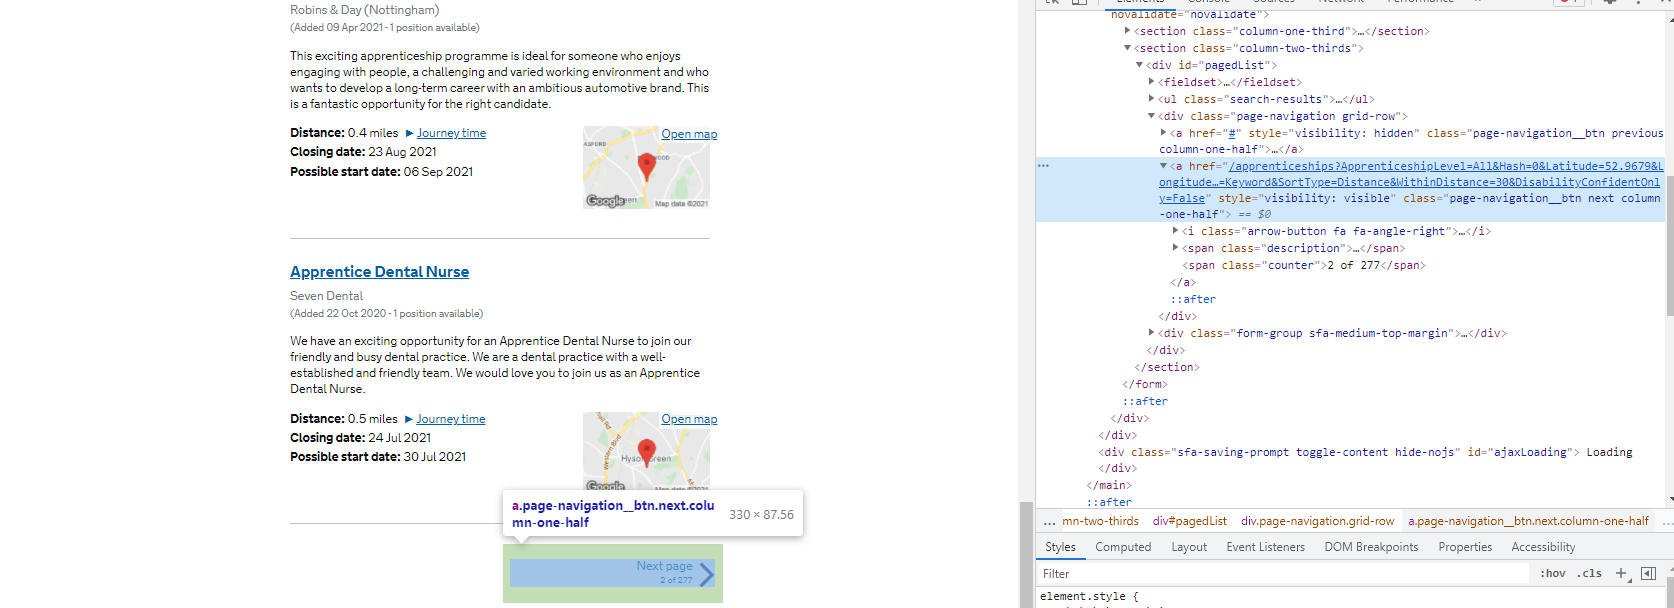

We will start with 

In [11]:
next_link = '/apprenticeships?' + '&'.join(f"{k}={urllib.parse.quote(str(v))}" for k, v in params.items())

Which is the same as in the earlier example. However, this time we will re-write the next link in our loop everytime we move page.

By inspecting the next page button (shown above) we can extract the URL by the following code:

In [12]:
next_link = soup.find('a', class_="next")['href']

Putting all of this inside a while loop which states that while the next link exists, run the code allows us to scrape over multiple pages.

The final piece of code is shown below.

In [13]:
occupation_description = []
company = []
apprenticeship_level = []
wage = []


next_link = '/apprenticeships?' + '&'.join(f"{k}={urllib.parse.quote(str(v))}" for k, v in params.items())

while next_link != '#':
    page = requests.get('https://www.findapprenticeship.service.gov.uk' + next_link)
    soup = BeautifulSoup(page.content, "html.parser")
    page_soup = soup.find(class_="search-results")

    next_link = soup.find('a', class_="next")['href']

    apprentice_cards = page_soup.find_all('li', class_="search-result")
    images = page_soup.find_all('img', class_='static-map')

    for container in apprentice_cards:
        occ_desc = container.find('a', class_='vacancy-link')
        occupation_description.append(occ_desc.text)
        
        comp = container.find('li', class_='secondary-text').text
        company.append(comp)

        apprentice_level = container.find('li', attrs={'data-show': 'DisplayApprenticeshipLevel'}).text
        apprentice_level = str.split(apprentice_level)[2]
        apprenticeship_level.append(apprentice_level)

        wages = container.find('li', attrs={'data-show': 'DisplayWage'}).text
        wages = str.split(wages, ':')[1].strip()
        wage.append(wages)
        

df_apprenticeships = pd.DataFrame({
        'occupationDescription': occupation_description,
        'company': company,
        'apprenticeshipLevel': apprenticeship_level,
        'wage': wage
})

In [14]:
df_apprenticeships

,occupationDescription,company,apprenticeshipLevel,wage
0,Level 3 Business Administrator Apprenticeship,RESPOND RECRUITMENT LIMITED,Advanced,£129.00 per week
1,Early Years Practitioner Apprentice,EDUCARE DAY NURSERIES AND NURSERY SCHOOLS LIMITED,Intermediate,£129.00 per week
2,Administration Apprentice,MZ'S ENTERPRISES LTD,Advanced,£168.75 per week
3,Dental Nurse Apprentice,Holly Tree House Dental Practice,Advanced,£129.00 per week
4,Customer Service Administration Apprenticeship,Staddons & Sons (Nottingham) Ltd,Intermediate,£175.00 per week
...,...,...,...,...
1358,Apprentice Pharmacy Service Assistant,BOOKACHEMIST RECRUITMENT LIMITED,Intermediate,£129.00 per week
1359,Accounts Apprentice,PHILIP BARNES & CO (UTTOXETER) LIMITED,Advanced,£161.25 per week
1360,Tax Advisor Apprentice,Croner,Higher,"£20,000.00 per year"
1361,Apprenticeship in Horse Care – Equine Groom Le...,Jordan Kavanagh,Intermediate,£129.00 per week


This now shows all of the apprenticeship opportunities within 30 miles of Nottingham.

There are so many uses of web scraping and this example is just scratching the surface! But hopefully this tutorial provides an introduction to the basics you need when wanting to scrape the web. 

**REMEMBER** Check the terms and conditions before you go ahead!